In [2]:
# Import Required Libraries
library(dplyr)
library(tsibble)
library(fable)
library(ggplot2)
library(tidyr)
library(purrr)
library(feasts)

# Source Helper Functions
source("../Baseline/baseline_helpers.R")
source("../Data_Inspection/data_cleaning_helpers.R")
source("./evaluation_helpers.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: ‘tsibble’


The following objects are masked from ‘package:base’:

    intersect, setdiff, union


Loading required package: fabletools


Attaching package: ‘lubridate’


The following object is masked from ‘package:tsibble’:

    interval


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [3]:
#library(future)
#workers <- parallel::detectCores() - 1

## Load data

In [4]:
# Load dates
dates <- read.csv("../calendar_afcs2025.csv") |> mutate(date = as.Date(date, format = "%m/%d/%Y"))
dates <- dates |> rename(day = date)

# added this later, might break everything, gotta check it
dates <- dates |> as_tsibble(index = day, key = wm_yr_wk)

# adding dummy variables for each weekday
dates <- dates |>
  mutate(
    wd_monday    = as.integer(weekday == "Monday"),
    wd_tuesday   = as.integer(weekday == "Tuesday"),
    wd_wednesday = as.integer(weekday == "Wednesday"),
    wd_thursday  = as.integer(weekday == "Thursday"),
    wd_friday    = as.integer(weekday == "Friday"),
    wd_saturday  = as.integer(weekday == "Saturday")
  )

dates <- dates |>
  mutate(
    m_january   = as.integer(month == 1),
    m_february  = as.integer(month == 2),
    m_march     = as.integer(month == 3),
    m_april     = as.integer(month == 4),
    m_may       = as.integer(month == 5),
    m_june      = as.integer(month == 6),
    m_july      = as.integer(month == 7),
    m_august    = as.integer(month == 8),
    m_september = as.integer(month == 9),
    m_october   = as.integer(month == 10),
    m_november  = as.integer(month == 11)
  )

# way too many unique event names so many we just focus on this,
# it's implemented with an or because event1 and event2 are always different type,
# and they can be in either order

# adding dummy variables for each event category
dates <- dates |>
  mutate(
    et_sporting  = as.integer((event_type_1 == "Sporting" | event_type_2 == "Sporting") %in% TRUE),
    et_cultural  = as.integer((event_type_1 == "Cultural" | event_type_2 == "Cultural") %in% TRUE),
    et_national  = as.integer((event_type_1 == "National" | event_type_2 == "National") %in% TRUE),
    et_religious = as.integer((event_type_1 == "Religious" | event_type_2 == "Religious") %in% TRUE)
  )


In [5]:
# Load train data
train <- get_train_and_validation_data_concatted(dates)

# Clean evaluation data
test <- get_evaluation_data()


## Baselines

Mean

In [53]:
means <- train |>
  as_tibble() |>
  group_by(product) |>
  summarise(mean_sales = mean(sales))

mean_forecasts <- new_data(ungroup(train), n = 28) |>
  left_join(means, by = "product") |>
  rename(sales = mean_sales) |>
  as_tibble()

aligned_data <- align_predictions(mean_forecasts, test)
accuracy_mean <- calculate_metrics(aligned_data)

Naive

In [21]:
path <- "models/baseline/naive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  print("Creating new model")
  fit <- train |>
    model(
      NAIVE(sales)
    )
  saveRDS(fit, path)
}


naive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(naive_forecasts, test)
accuracy_naive <- calculate_metrics(aligned_data)
naive_augmented <- fit |> augment()

[1] "Using existing model"


sNaive

In [22]:
path <- "models/baseline/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  print("Creating new model")
  fit <- train |>
    model(
      SNAIVE(sales)
    )
  saveRDS(fit, path)
}

snaive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(snaive_forecasts, test)
accuracy_snaive <- calculate_metrics(aligned_data)
snaive_augmented <- fit |> augment()


[1] "Using existing model"


ARIMA

In [23]:
path <- "models/baseline/arima.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  #plan(multisession, workers = workers) # Worker function for parallel processing
  print("Creating new model")
  fit <- train |>
    model(
      ARIMA(sales)
    )
  saveRDS(fit, path)
  #plan(sequential)
}

arima_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(arima_forecasts, test)
accuracy_arima <- calculate_metrics(aligned_data)
arima_augmented <- fit |> augment()

[1] "Using existing model"


ETS

In [24]:
path <- "models/baseline/ets.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  #plan(multisession, workers = workers) # Worker function for parallel processing
  print("Creating new model")
  fit <- train |>
    model(
      ETS(sales)
    )
  saveRDS(fit, path)
  #plan(sequential)
}

ets_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(ets_forecasts, test)
accuracy_ets <- calculate_metrics(aligned_data)
ets_augmented <- fit |> augment()

[1] "Using existing model"


Evaluate baselines

# A tibble: 5 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 mean    6.13  2.13
2 naive   4.66  2.05
3 snaive  4.14  1.86
4 arima   3.73  1.54
5 ets     3.71  1.55


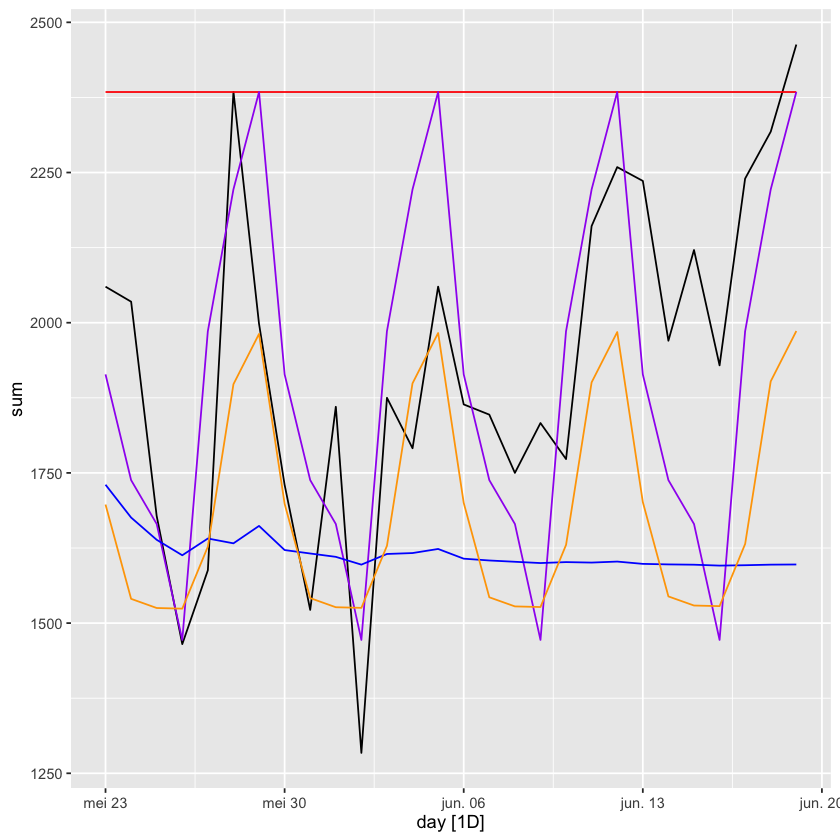

In [12]:
sums_mean <- mean_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_naive <- naive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_arima <- arima_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_ets <- ets_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_test <- test |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

# accuracy table
baseline_accuracy <- bind_rows(
  mean = accuracy_mean,
  naive = accuracy_naive,
  snaive = accuracy_snaive,
  arima = accuracy_arima,
  ets = accuracy_ets,
  .id = "model"
)

print(baseline_accuracy)

# plotting against validation to see what is being captured
(sums_test |> autoplot(.vars = sum)) +
  autolayer(sums_naive, sum, color = "red") +
  autolayer(sums_snaive, sum, color = "purple") +
  autolayer(sums_arima, sum, color = "blue") +
  autolayer(sums_ets, sum, color = "orange")


## ARIMA

In [35]:
path <- "models/arima_model.rds"

if (file.exists(path)) {
  arima_fit <- readRDS(path)
} else {
  arima_fit <- train |>
    model(
      ARIMA(sales ~ sell_price)
    )

  saveRDS(arima_fit, path)
}


sNaive price performs best

In [36]:
path <- "models/prices/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  price_fit_snaive <- readRDS(path)
} else {
  # fitting a seasonal naive
  price_fit_snaive <- train |>
    model(SNAIVE(sell_price))

  saveRDS(price_fit_snaive, path)
}

# forecast price
sell_price_future_snaive <- price_fit_snaive |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)

# forecast sales based on this price as future data
snaive_forecasts <- forecast(arima_fit, new_data = sell_price_future_snaive) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, test)
accuracy_snaive <- calculate_metrics(aligned_data)


In [37]:
sell_price_future_snaive_cal <- inner_join(
    sell_price_future_snaive,
    dates,
    by = c("day")
)

Incorporate calendar predictors

In [38]:
# This is for parallel processing

#library(future)
#workers <- parallel::detectCores() - 1
#plan(multisession, workers = workers)

In [39]:
path <- "models/arima_models/arima_model_cal_snap_events.rds"

if (file.exists(path)) {
  arima_fit_cal_first <- readRDS(path)
} else {
  arima_fit_cal_first <- train |>
    model(
      ARIMA(
        sales ~ sell_price +

          # events
          et_sporting + et_cultural +
          et_national + et_religious +

          snap_TX,
          stepwise = TRUE,
          approximation = TRUE
      )
    )

  saveRDS(arima_fit_cal_first, path)
}

In [40]:
arima_fit_cal_first <- arima_fit_cal_first |>
  rename(model = last_col())

get products with null models

In [41]:
null_products <- arima_fit_cal_first |> 
      as_tibble() |>
      filter(map_lgl(model, is_null_model)) |> 
      select(product)

In [42]:
refit_nulls <- train |>
  semi_join(null_products, by = "product") |>
  model(
    model = ARIMA(sales ~  pdq(0:1, 0:1, 0:1) + 
          snap_TX)
  )


Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”


In [43]:
refit_nulls |> as_tibble() |>
      filter(map_lgl(model, is_null_model)) |> 
      select(product)

product
<chr>


In [44]:
good_models <- arima_fit_cal_first |>
  filter(!map_lgl(model, is_null_model))
head(good_models)

product,model
<chr>,<model>
FOODS_3_001,"<LM w/ ARIMA(2,1,2)(1,0,1)[7] errors>"
FOODS_3_002,"<LM w/ ARIMA(3,1,2)(1,0,0)[7] errors>"
FOODS_3_003,"<LM w/ ARIMA(3,1,1)(2,0,0)[7] errors>"
FOODS_3_004,"<LM w/ ARIMA(0,0,0)(1,0,0)[7] errors>"
FOODS_3_005,"<LM w/ ARIMA(3,0,1)(1,0,1)[7] errors>"
FOODS_3_007,"<LM w/ ARIMA(1,1,2)(0,0,1)[7] errors>"


In [45]:
arima_fit_fixed <- bind_rows(
  good_models,
  refit_nulls
)
arima_fit_cal <- arima_fit_fixed

# A tibble: 1 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 snaive  3.68  1.54


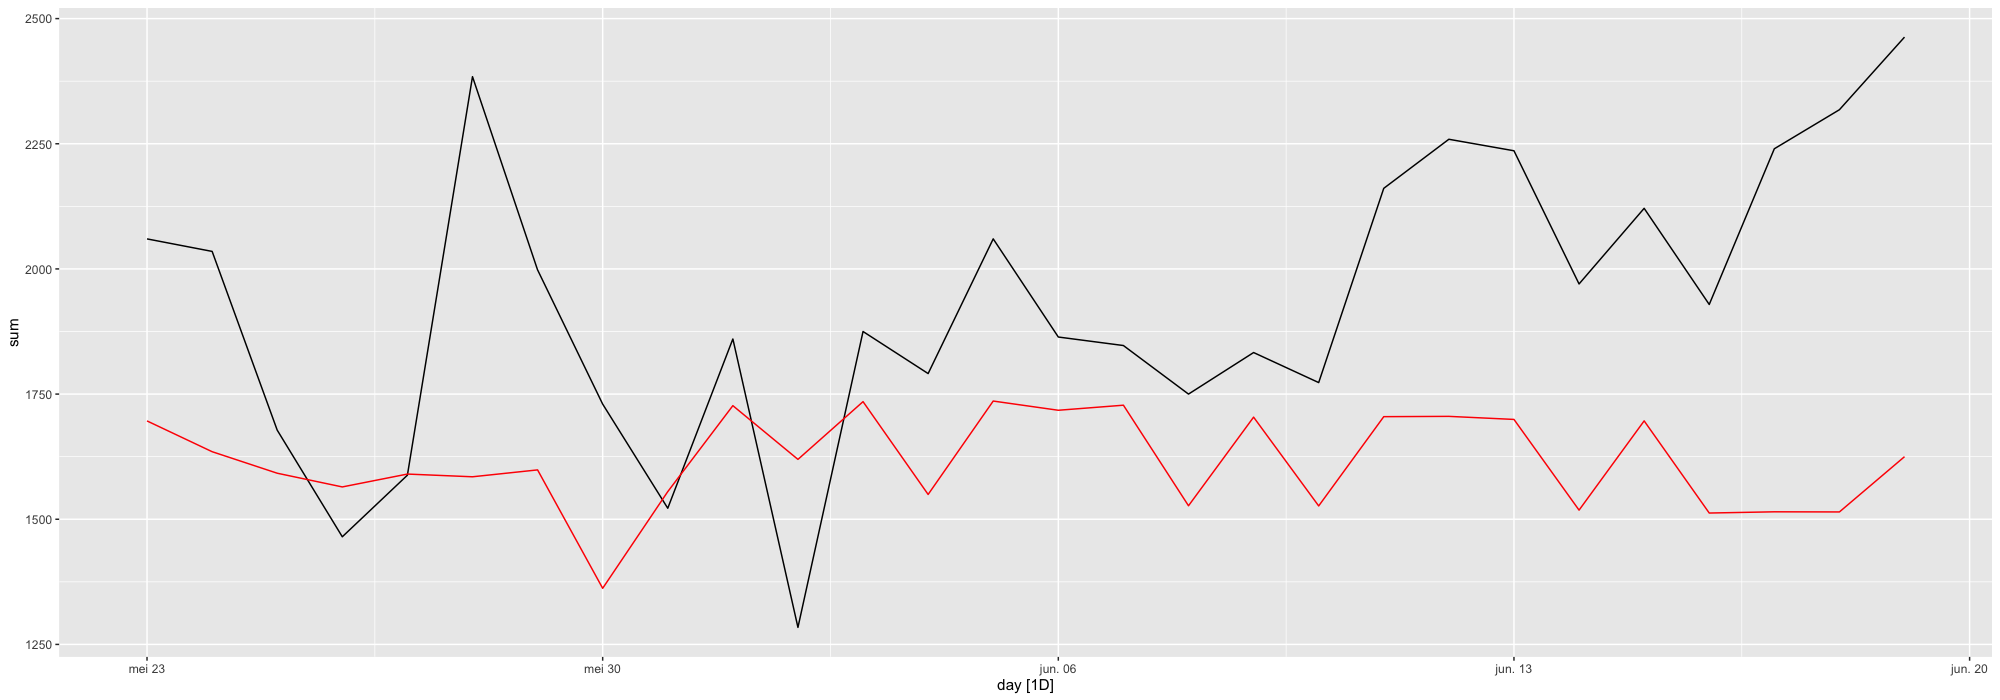

In [46]:
# snaive
snaive_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_snaive_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, test)
accuracy_snaive <- calculate_metrics(aligned_data)

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_test <- test |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

# accuracy table
dynamic_price_accuracy <- bind_rows(
  snaive = accuracy_snaive,
  .id = "model"
)

print(dynamic_price_accuracy)

# plotting against validation to see what is being captured
(sums_test |> autoplot(.vars = sum)) +
  autolayer(sums_snaive, sum, color = "red")

## Hurdle

In [47]:
options(repr.plot.width = 20, repr.plot.height = 7, repr.plot.res = 100)

In [7]:
h <- 28

sell_price_future <- generate_future_sell_prices(
    price_model = fit_or_load_price_model(train, force_fit = FALSE),
    date_events = dates,
    h = h
)

feat_int <- train |>
    as_tibble() |>
    group_by(product) |>
    summarise(intermittency_features(sales), .groups = "drop")


median_sparsity <- median(feat_int$p_zero)
cat("Median Sparsity (Proportion of zero daily sales across all products): ", round(median_sparsity, 4), "\n")

Median Sparsity (Proportion of zero daily sales across all products):  0.5564 


In [8]:
# Update the regime classification based on the new median sparsity
feat <- feat_int |>
    mutate(
        # regime = if_else(p_zero >= max(feat_int$p_zero), "sparse", "dense")
        # regime = if_else(p_zero > median_sparsity, "sparse", "dense")
        regime = "sparse" # TODO CHANGE BACK
    )


In [9]:
# Fit models to sparse products
sparse_products <- feat |>
    filter(regime == "sparse") |>
    pull(product)

hurdle_models <- fit_or_load_hurdle_models(train, sparse_products, force_fit = FALSE)

In [10]:
# Do an actual prediction using the models on the test data and evaluate:
# Predict using the models on the future_data and evaluate against validation:

predictions <- generate_hurdle_predictions(hurdle_models, h, sell_price_future, sparse_products)
print("Predictions:")
print(head(predictions))

Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknown or uninitialised column: `sales`.”
Warning message:
“Unknow

[1] "Predictions:"
# A tsibble: 6 x 5 [1D]
# Key:       product [1]
  day         y_hat  p_hat mu_hat product    
  <date>      <dbl>  <dbl>  <dbl> <chr>      
1 2016-05-23 0.0892 0.113   0.791 FOODS_3_001
2 2016-05-24 0.143  0.171   0.839 FOODS_3_001
3 2016-05-25 0.0480 0.0630  0.762 FOODS_3_001
4 2016-05-26 0.0819 0.0999  0.820 FOODS_3_001
5 2016-05-27 0.0898 0.115   0.783 FOODS_3_001
6 2016-05-28 0.0841 0.105   0.799 FOODS_3_001


In [11]:
# Ensure `product` column exists in both datasets before join
eval_data <- test |>
    inner_join(predictions, by = c("product", "day"))

In [12]:
aligned_data <- align_predictions(
    formatted_predictions = predictions |> rename(sales = y_hat),
    validation = test
)
cat("Evaluation Metrics:\n")
metrics <- calculate_metrics(aligned_data)
print(metrics)
final_products_and_errors <- calculate_metrics(aligned_data |> group_by(product)) |> arrange(-RMSE)

Evaluation Metrics:
# A tsibble: 28 x 3 [1D]
   day         RMSE   MAE
   <date>     <dbl> <dbl>
 1 2016-05-23  5.67  2.19
 2 2016-05-24  7.03  2.21
 3 2016-05-25  4.56  1.76
 4 2016-05-26  3.78  1.56
 5 2016-05-27  5.19  1.71
 6 2016-05-28  8.14  2.55
 7 2016-05-29  6.20  2.11
 8 2016-05-30  5.57  1.85
 9 2016-05-31  4.32  1.64
10 2016-06-01  5.17  1.97
# ℹ 18 more rows


Warning message:
“Current temporal ordering may yield unexpected results.
ℹ Suggest to sort by `product`, `day` first.”


In [13]:
final_metrics <- compare_errors_with_mean_baseline(train, test, h)

[1] "Mean Forecast Baseline Metrics:"
# A tibble: 1 × 2
   RMSE   MAE
  <dbl> <dbl>
1  6.13  2.13
Final Evaluation Metrics after replacing worst products with mean forecasts:
# A tsibble: 28 x 3 [1D]
   day         RMSE   MAE
   <date>     <dbl> <dbl>
 1 2016-05-23  5.67  2.20
 2 2016-05-24  7.01  2.21
 3 2016-05-25  4.54  1.77
 4 2016-05-26  3.76  1.56
 5 2016-05-27  5.19  1.72
 6 2016-05-28  8.17  2.56
 7 2016-05-29  6.22  2.11
 8 2016-05-30  5.54  1.85
 9 2016-05-31  4.30  1.65
10 2016-06-01  5.17  1.97
# ℹ 18 more rows


In [14]:
# Print average error

final_metrics |>
    as_tibble() |>
    summarise(
        RMSE = mean(RMSE, na.rm = TRUE),
        MAE = mean(MAE, na.rm = TRUE)
    )

RMSE,MAE
<dbl>,<dbl>
5.98663,2.108949


## Diagnostic checks

Naive baseline

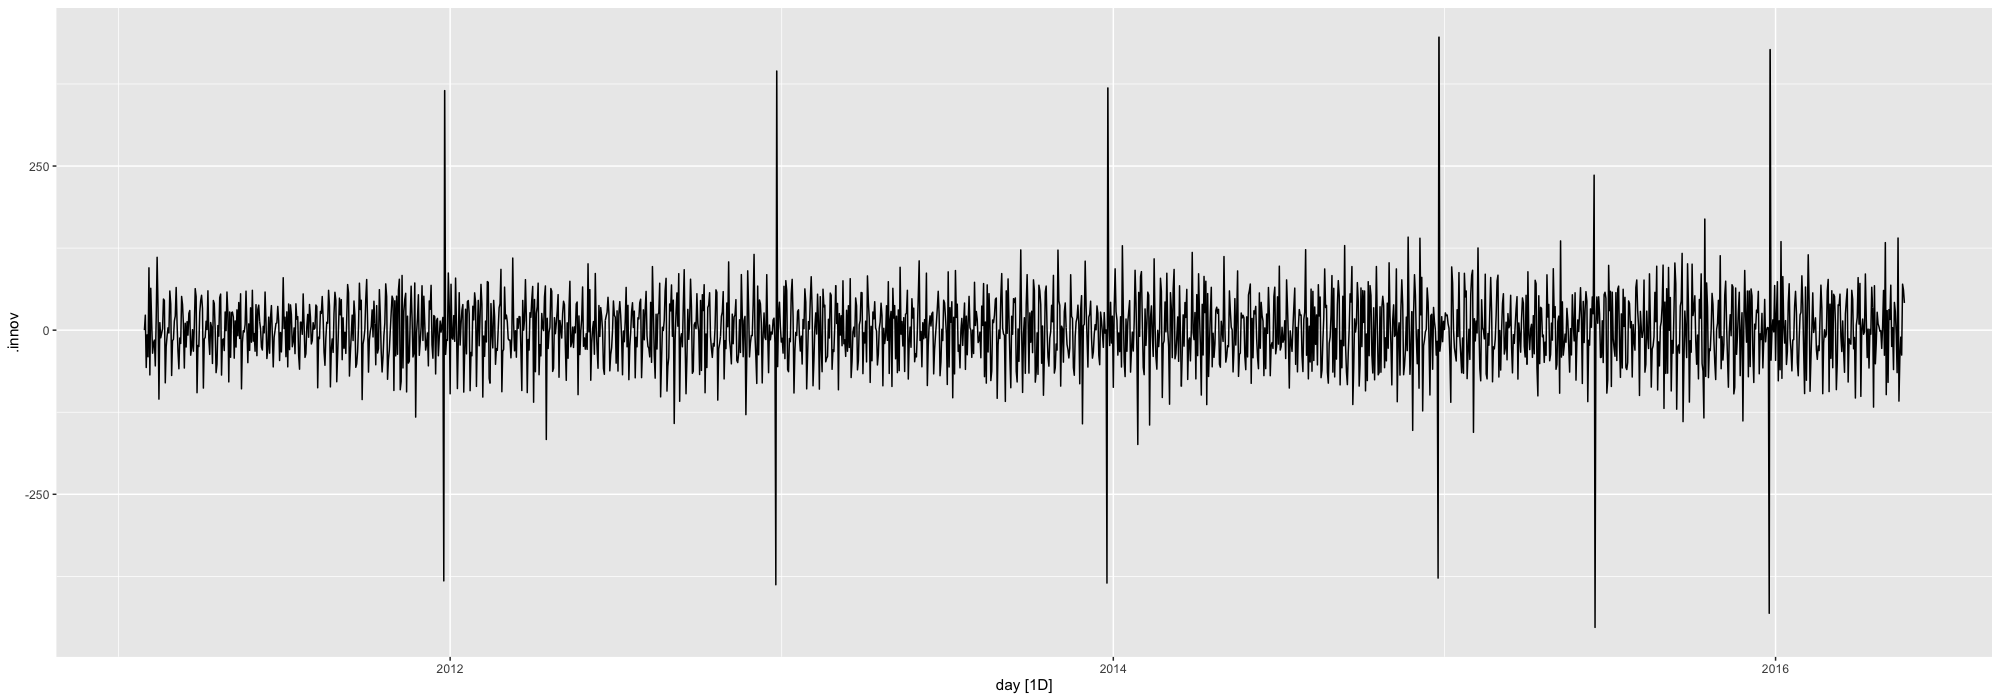

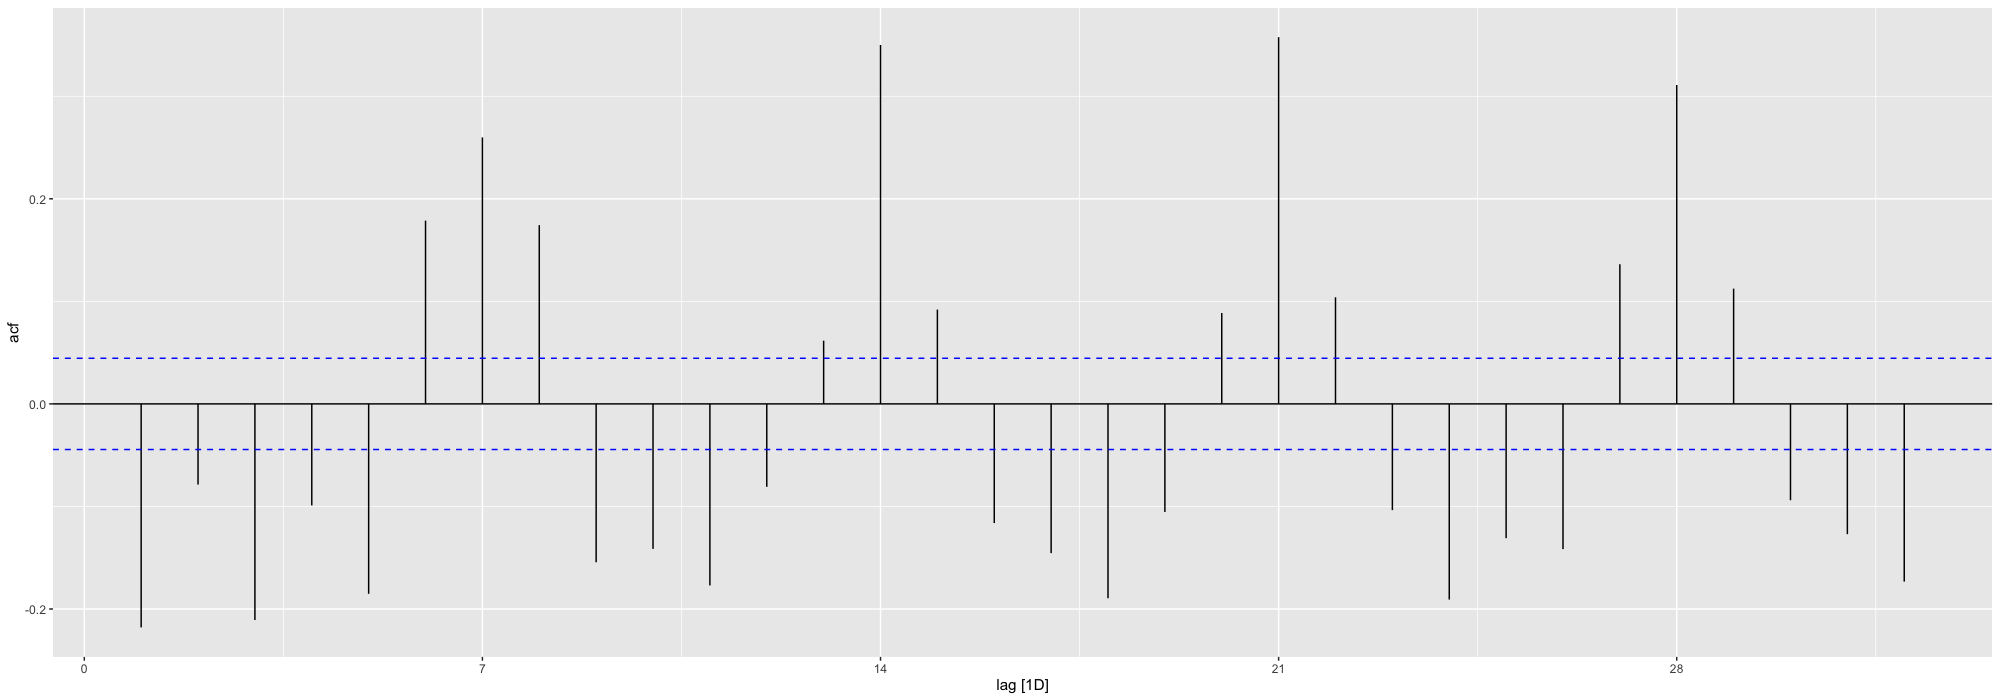

In [25]:
naive_innov <- naive_augmented |> 
    as_tibble() |>
    group_by(day) |>
    summarise(
        .innov = sum(.innov, na.rm = TRUE)
    ) |>
    as_tsibble(index = day)

naive_innov |>
    autoplot(.innov)

naive_innov |>
    ACF(.innov) |>
    autoplot()

In [26]:
Box.test(
  naive_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)


	Box-Ljung test

data:  naive_innov$.innov
X-squared = 936.81, df = 14, p-value < 2.2e-16


sNaive baseline

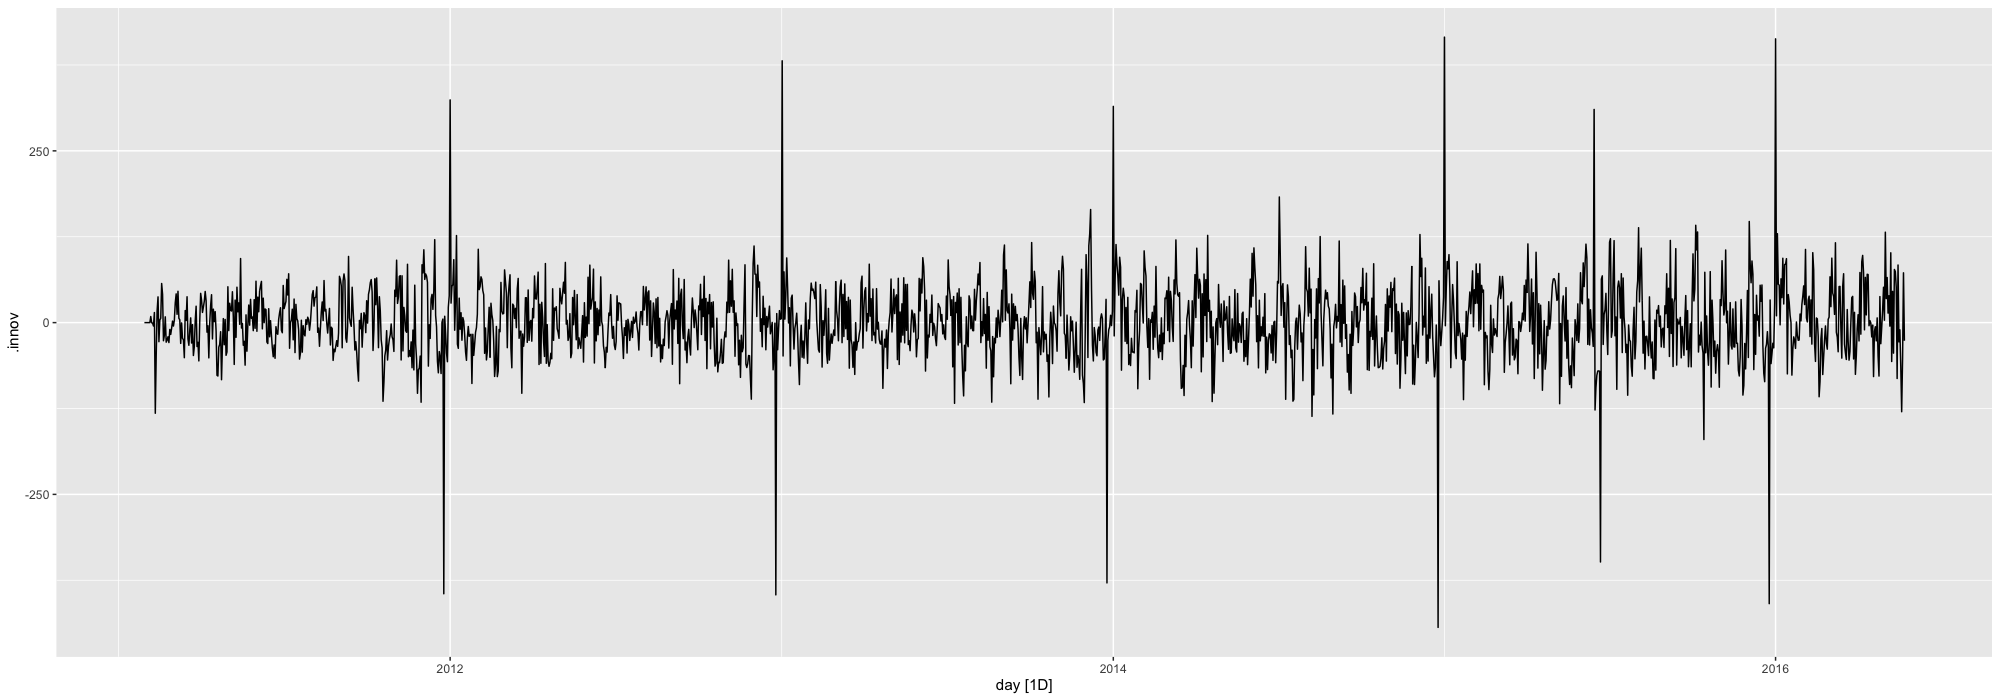

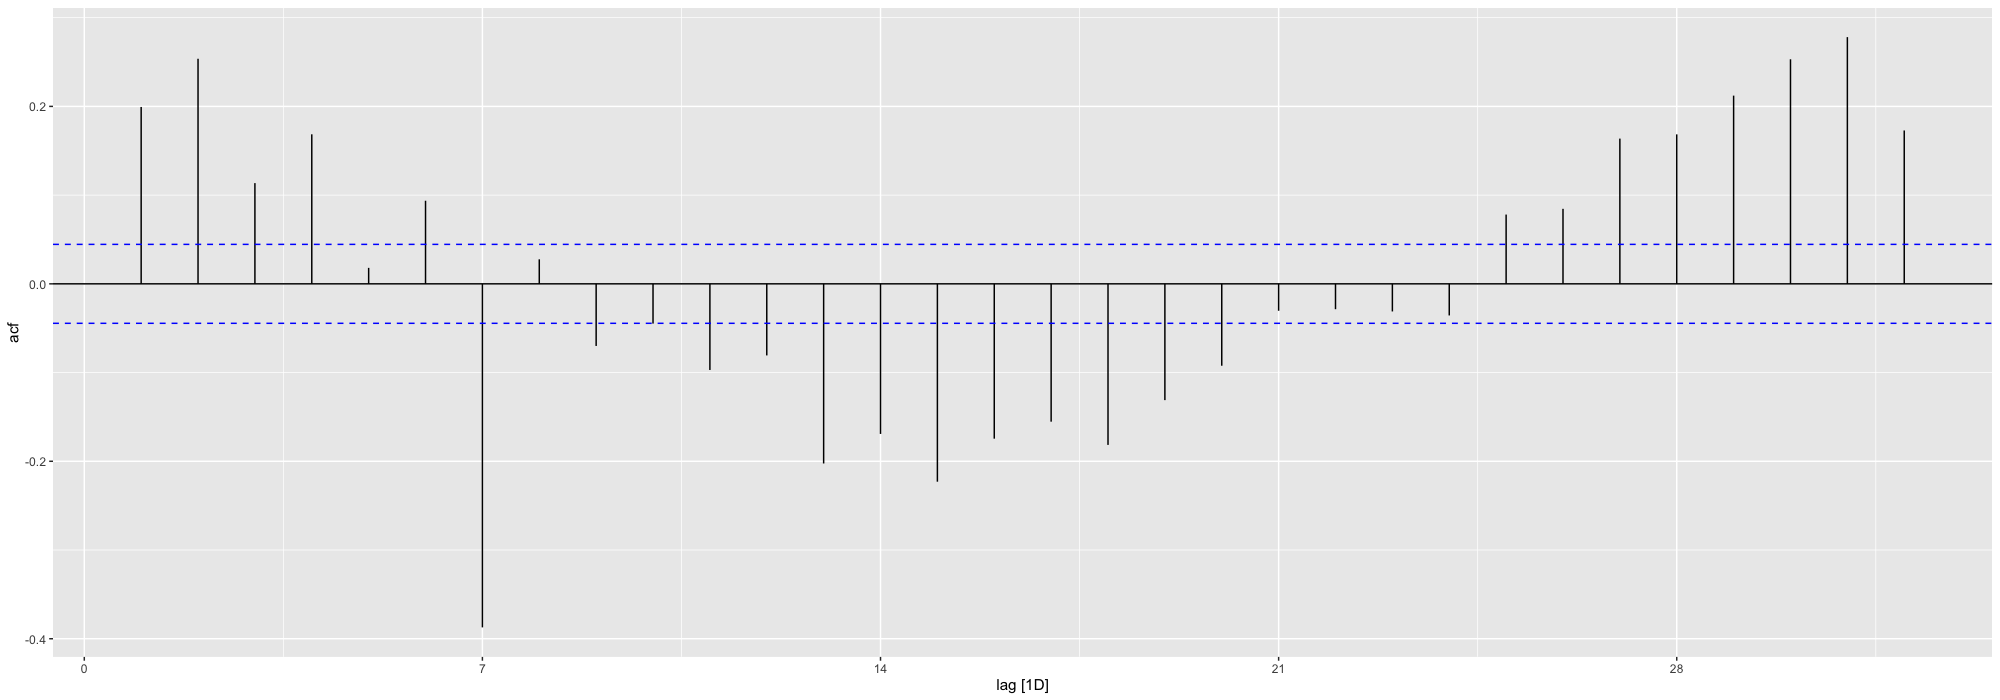

In [27]:
snaive_innov <- snaive_augmented |> 
    as_tibble() |>
    group_by(day) |>
    summarise(
        .innov = sum(.innov, na.rm = TRUE)
    ) |>
    as_tsibble(index = day)

snaive_innov |>
    autoplot(.innov)

snaive_innov |>
    ACF(.innov) |>
    autoplot()

In [28]:
Box.test(
  snaive_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)


	Box-Ljung test

data:  snaive_innov$.innov
X-squared = 775.26, df = 14, p-value < 2.2e-16


ETS baseline

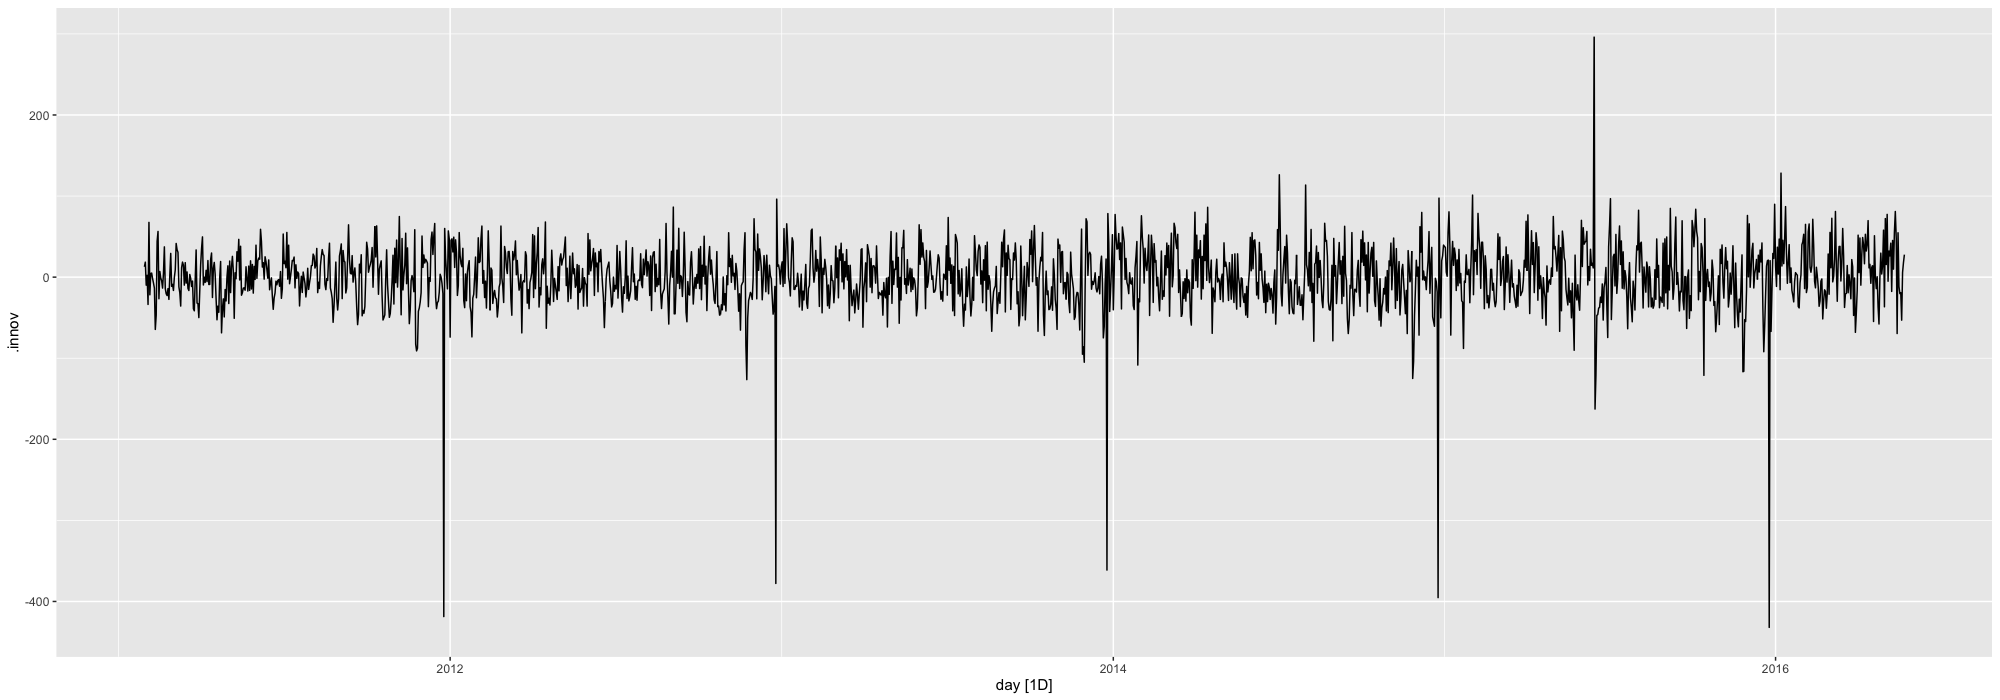

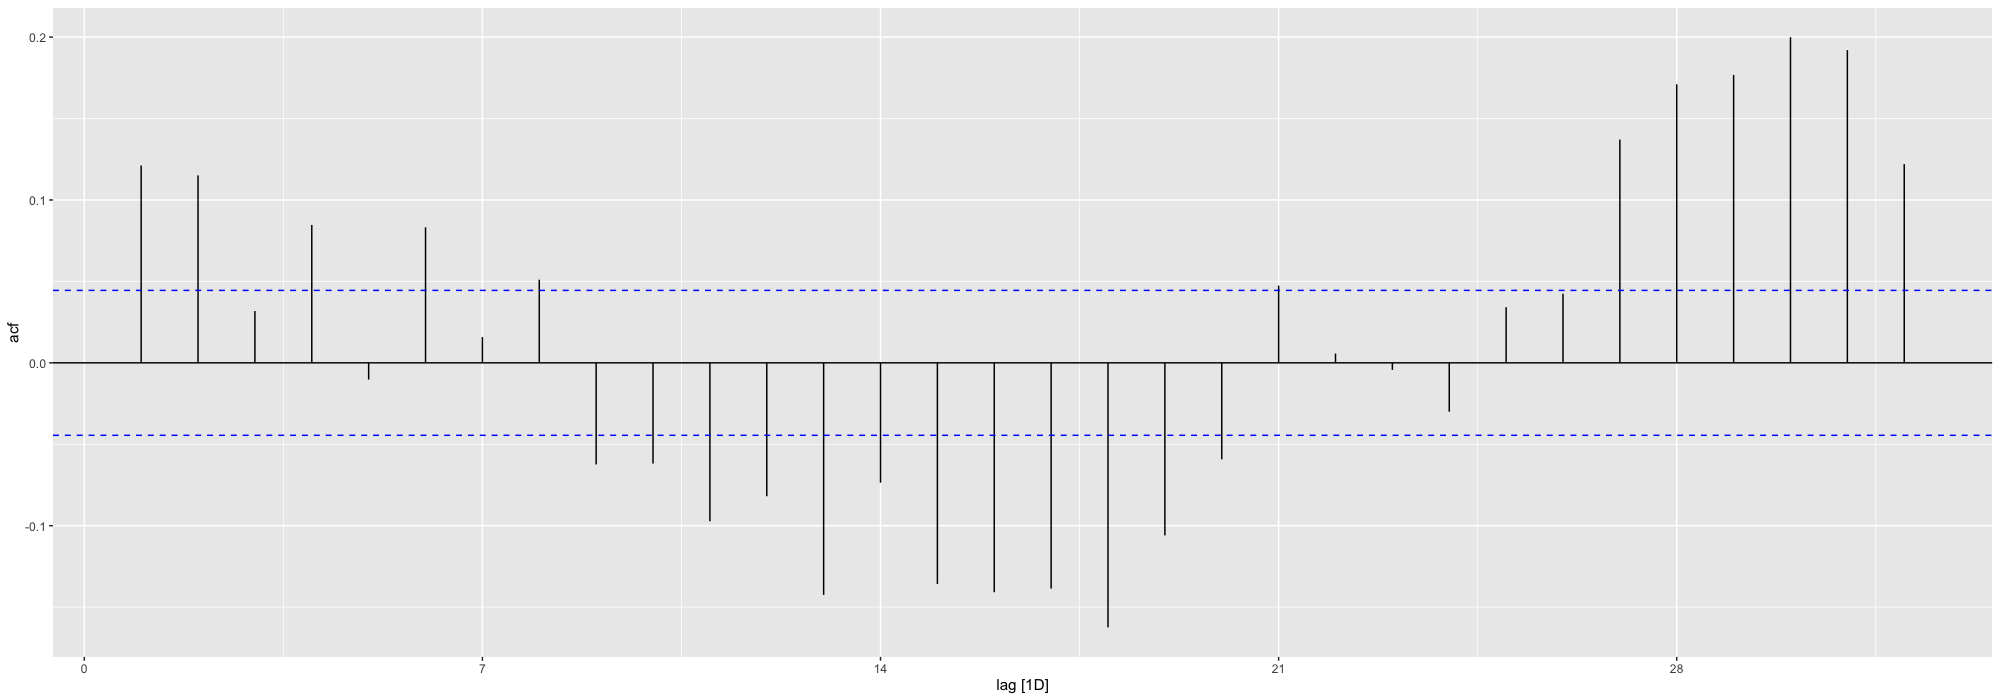

In [29]:
ets_innov <- ets_augmented |> 
    as_tibble() |>
    group_by(day) |>
    summarise(
        .innov = sum(.innov, na.rm = TRUE)
    ) |>
    as_tsibble(index = day)

ets_innov |>
    autoplot(.innov)

ets_innov |>
    ACF(.innov) |>
    autoplot()

In [30]:
Box.test(
  ets_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)


	Box-Ljung test

data:  ets_innov$.innov
X-squared = 186.52, df = 14, p-value < 2.2e-16


ARIMA baseline

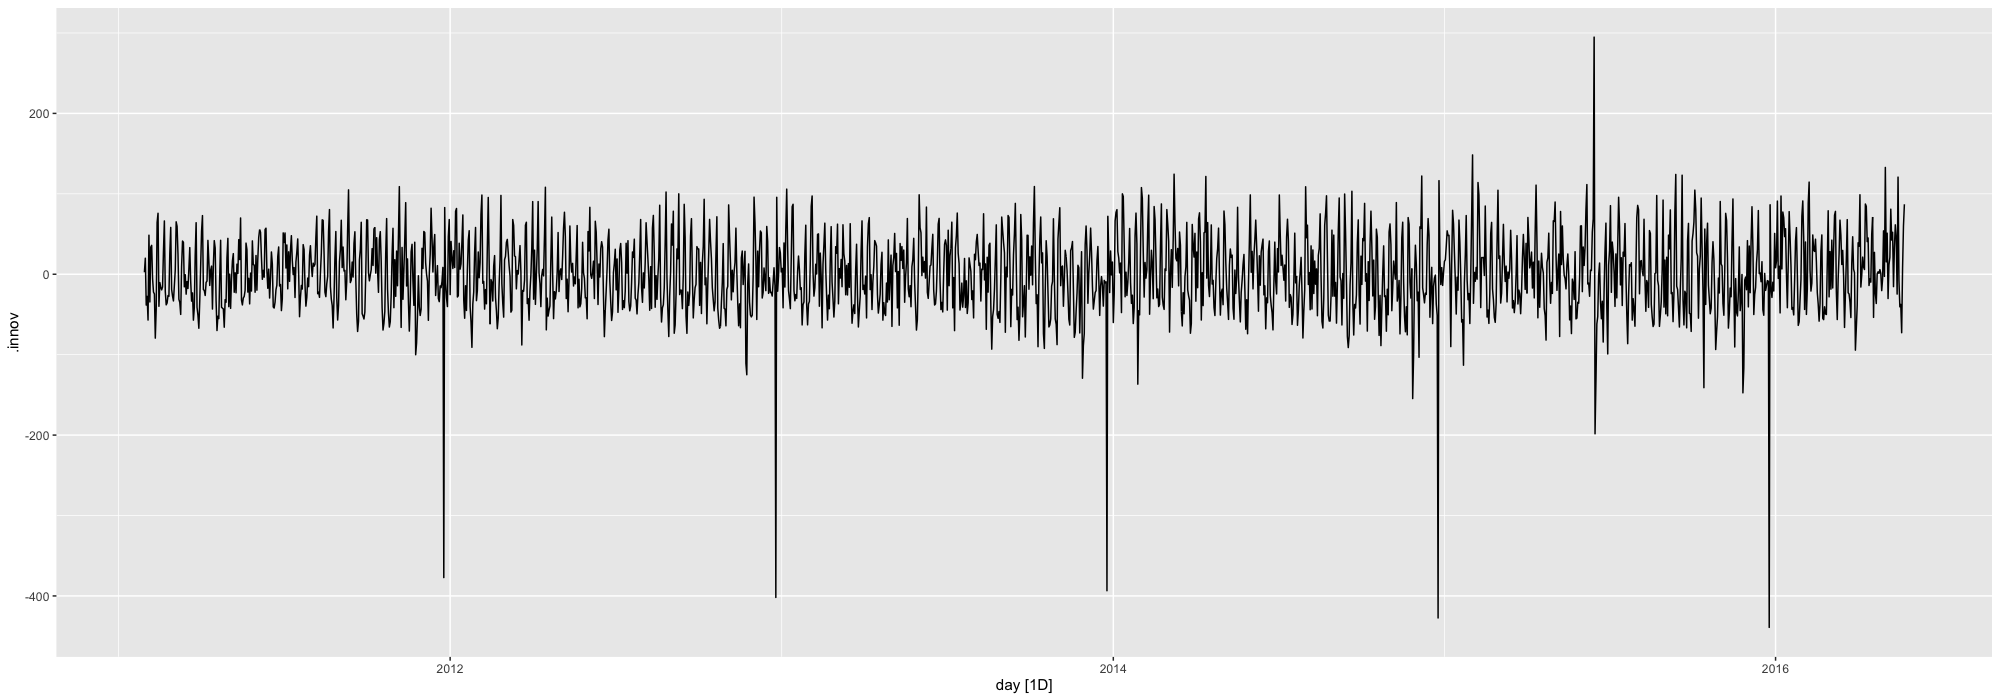

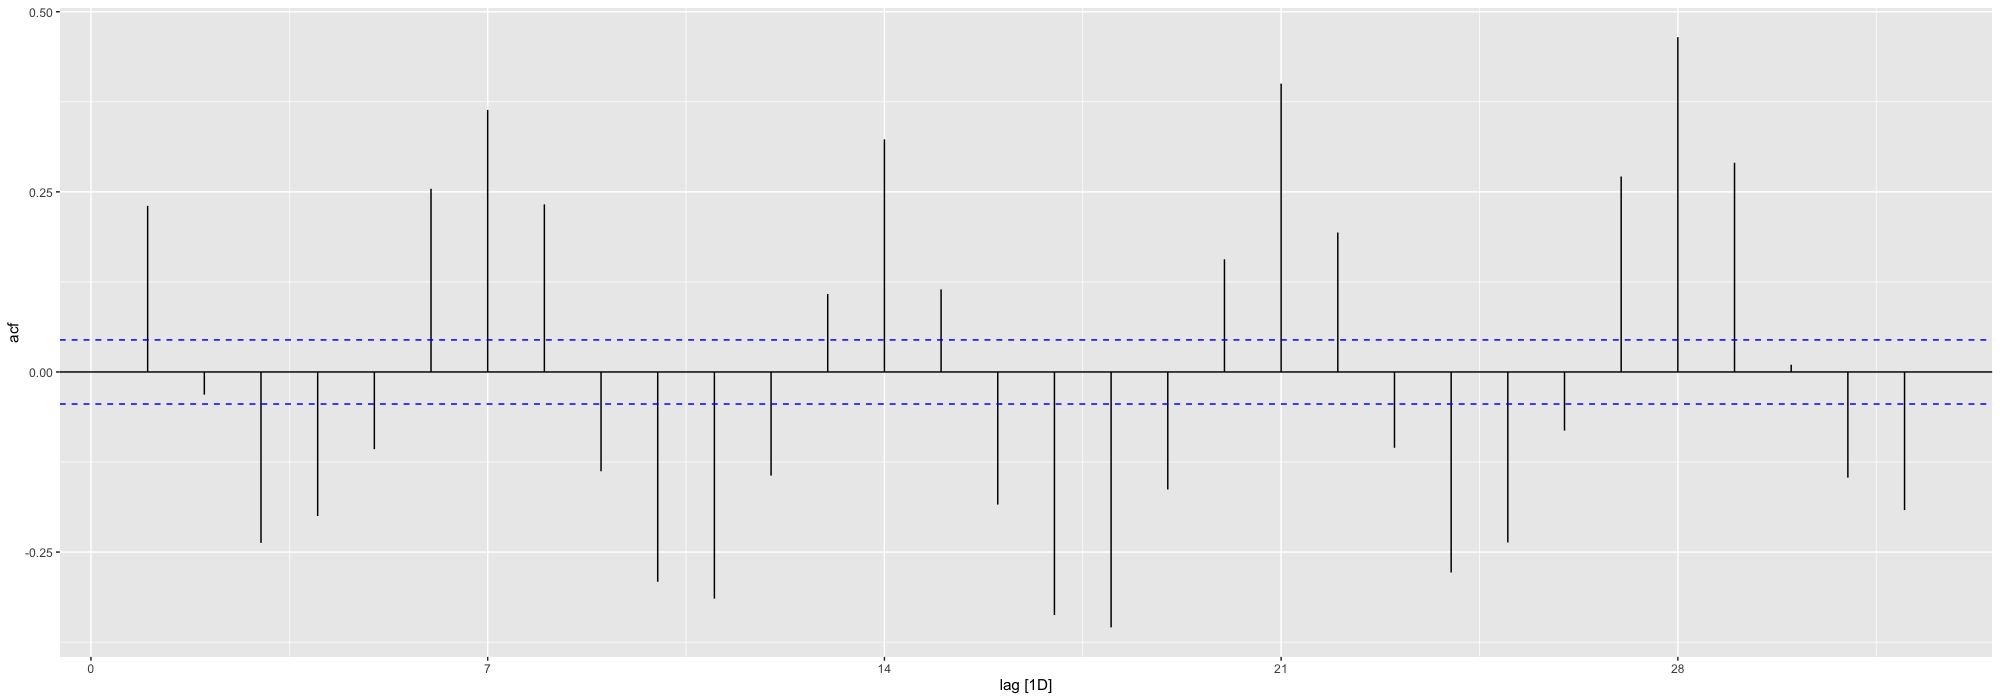

In [31]:
arima_innov <- arima_augmented |> 
    as_tibble() |>
    group_by(day) |>
    summarise(
        .innov = sum(.innov, na.rm = TRUE)
    ) |>
    as_tsibble(index = day)

arima_innov |>
    autoplot(.innov)

arima_innov |>
    ACF(.innov) |>
    autoplot()

In [32]:
Box.test(
  arima_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)


	Box-Ljung test

data:  arima_innov$.innov
X-squared = 1468.2, df = 14, p-value < 2.2e-16


ARIMA with events and SNAP

In [48]:
arima_fit_cal_augmented <- arima_fit_cal |> augment()

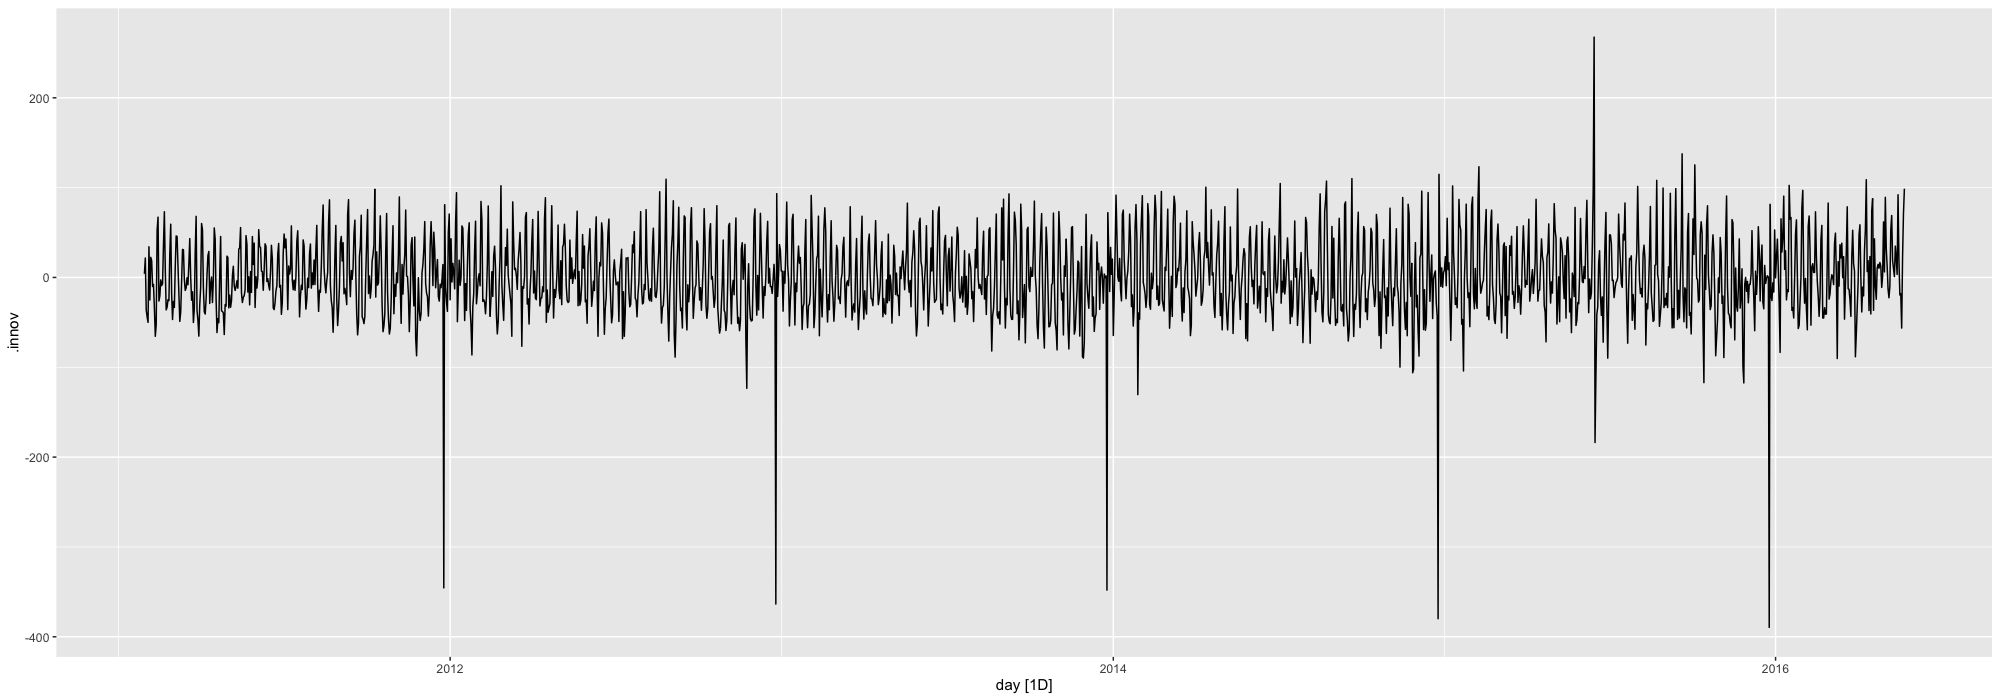

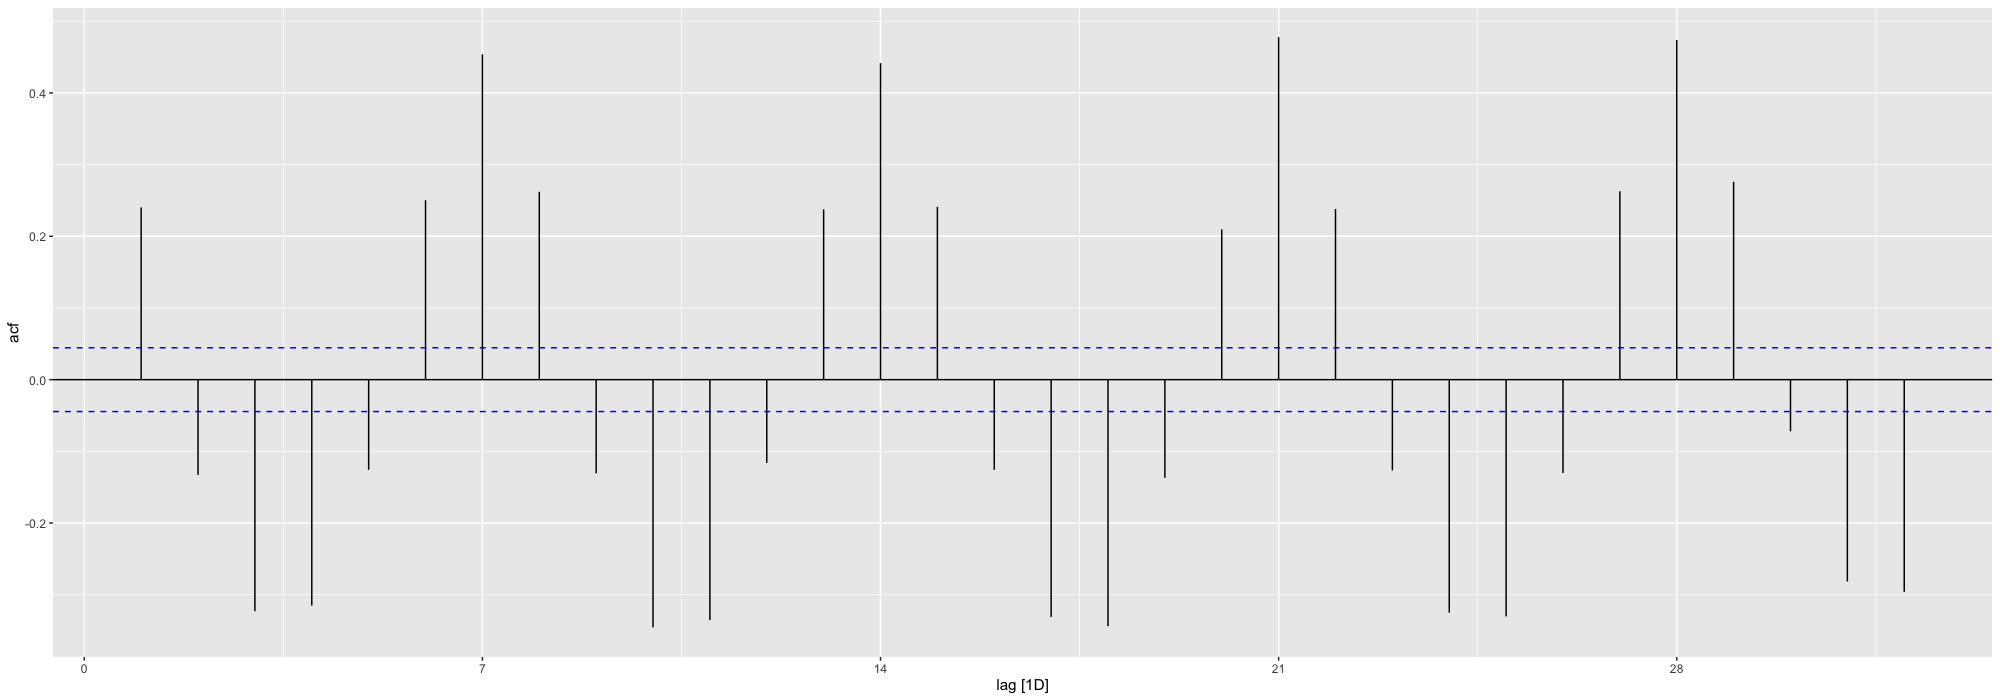

In [49]:
arima_fit_cal_innov <- arima_fit_cal_augmented |> 
    as_tibble() |>
    group_by(day) |>
    summarise(
        .innov = sum(.innov, na.rm = TRUE)
    ) |>
    as_tsibble(index = day)

arima_fit_cal_innov |>
    autoplot(.innov)

arima_fit_cal_innov |>
    ACF(.innov) |>
    autoplot()

In [50]:
Box.test(
  arima_fit_cal_innov$.innov,
  lag = 14,
  type = "Ljung-Box"
)


	Box-Ljung test

data:  arima_fit_cal_innov$.innov
X-squared = 2235.8, df = 14, p-value < 2.2e-16
